# Analisis Nilai SAT pada Sekolah NYC
Pada analisis ini saya akan menganalisis bagaimana aspek-aspek tertentu mempengaruhi skor SAT pada siswa/siswi SMA NYC. Apakah nilai SAT menguntungkan bagi beberapa golongan tertentu atau memang SAT sudah penilaian paling adil. Ada beberapa dataset yang akan digunakan dalam analisis kali ini yaitu:

- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) : Skor SAT untuk tiap SMA di NYC
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt)    : Informasi kehadiran untuk tiap SMA di NYC
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)           : Informasi besar kelas untuk tiap SMA di NYC
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e)      : Hasil Advanced Placement (AP) 
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a)  : informasi kelulusan SMA NYC
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j)         : Informasi demografik tiap SMA NYC
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8)        : Surbey orang tua,guru,dan siswa/siswi tiap sekolah

Setelah itu kita baca data diatas. Tiap data ada di folder schools dan nama tiap data adalah sebagai berikut:
- ap_2010.csv - Data on AP test results
- class_size.csv - Data on class size
- demographics.csv - Data on demographics
- graduation.csv - Data on graduation outcomes
- hs_directory.csv - A directory of high schools
- sat_results.csv - Data on SAT scores
- survey_all.txt - Data on surveys from all schools
- survey_d75.txt - Data on surveys from New York City district 75

# Membaca Data

In [3]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}
#Tiap data dimasukkan ke dalam dictionary dengan keynya adalah nama file 
#tanpa csv
for d in data_files:
    file = d.replace('.csv','')
    df = pd.read_csv('schools/'+d)
    data[file] = df
    
#Mencek 5 baris pertama
print(data['sat_results'].head())


      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

Dari data diatas kita dapat menilai bahwa:
- Pada data yang digunakan kolom DBN adalah kode unik tiap sekolah yang dapat digunakan untuk menggabungkan data nantinya
- Kita mungkin ingin menggabung kolom  SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score untuk memudahkan analisis
- Walau DBN unik pada 5 baris pertama tapi kita tetap harus mencek apakah semua baris mempunyai DBN unik dan bagaimana jika ada DBN yang tidak unik

# Membaca File Survey
File ini terencode dengan Windows-1252 sehingga harus diperlakukan berbeda dengan data lainnya. Selain itu kedua file survey akan kita jadikan satu dan kolomnya akan difilter yang relevan saja. 
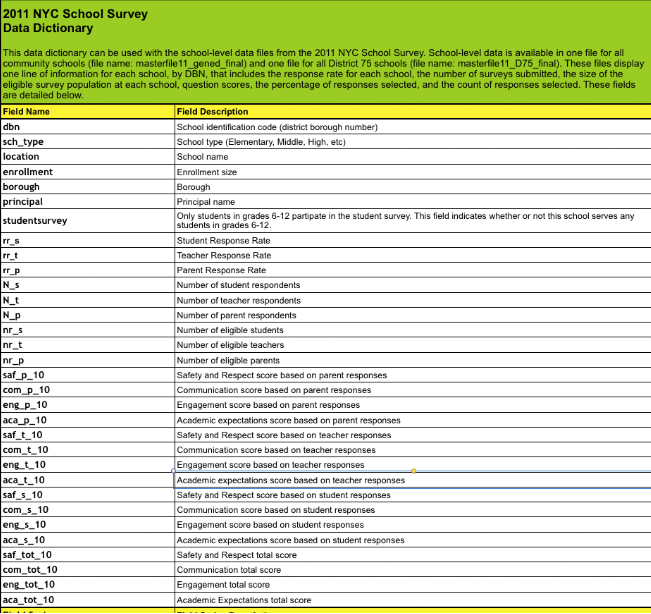
Kolom yang dianggap relevan adalah kolom yang tercantum pada list survey_fields dibawah.

In [4]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]
#Menggunakan kolom yang relevan saja
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Menambah Kolom DBN
Pada data class_size tidak terdapat kolom DBN namun ada kolom CSD dan School Code yang jika digabungkan akan membuat DBN yang unik. Cara membuat DBN yang sesuai adalah CSD ditambah 0 didepannya jika hanya 1 angka dan jika 2 angka tetap. Lalu dibelakang CSD akan ditambah school code.

In [5]:
#Merename agar semua kolom sesuai DBN
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]


data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(lambda x: '0'+str(x) if len(str(x))<2 else str(x))
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
#Cek apakah sudah benar
print(data["class_size"]["DBN"].head())

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object


# Memanipulasi Kolom Tertentu
Ada beberapa kolom yang kita ubah untuk analisa kedepan, yaitu kolom skor SAT yang terpisah pada data "sat_results" akan kita gabungkan menjadi satu skor total untuk memudahkan analisa data. Setelah itu kita akan mengambil data koordinat dari kolom "Location 1" pada data "hs_directory"

In [6]:
print(data['hs_directory']["Location 1"].head())

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object


Untuk mengambil koordinat kita butuh longitude dan latitude yang terdapat didalam (lat,long) pada kolom "Location 1" untuk itu kita memakai re.findal dibawah

In [7]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
data['sat_results']['sat_score'] = 0
for c in cols:
    #error='coerce' dipakai agar string yang tidak bisa dikonvert dianggap 
    #sebagai NaN
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")
    data['sat_results']['sat_score'] += data['sat_results'][c] 

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Memfilter Dataset
Beberapa data yang digunakan masih mempunyai beberapa baris dengan DBN yang sama. Karena itu kita akan membersihkan data lebih lanjut sebelum disatukan. 

In [8]:
print(data["class_size"].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


Kita lihat  sekolah dengan DBN yang sama terdiri dari beberapa baris. Hal ini dikarenakan tiap grade dan program type dipisahkan sehingga membuat satu sekolah memiliki beberapa baris. Untuk menghindari hal tersebut kita akan memfilter dataset ini dengan kolom "grade"= 09-12 dan kolom "program type" GEN ED saja. Hal ini karena Skor SAT hanya dimiliki siswa SMA saja yang berarti kelas 9-12 dan GEN ED dipilih karena paling umum.

In [9]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
print(class_size.head())

     CSD BOROUGH SCHOOL CODE                                    SCHOOL NAME  \
225    1       M        M292  Henry Street School for International Studies   
226    1       M        M292  Henry Street School for International Studies   
227    1       M        M292  Henry Street School for International Studies   
228    1       M        M292  Henry Street School for International Studies   
229    1       M        M292  Henry Street School for International Studies   

    GRADE  PROGRAM TYPE CORE SUBJECT (MS CORE and 9-12 ONLY)  \
225  09-12       GEN ED                              ENGLISH   
226  09-12       GEN ED                              ENGLISH   
227  09-12       GEN ED                              ENGLISH   
228  09-12       GEN ED                              ENGLISH   
229  09-12       GEN ED                                 MATH   

    CORE COURSE (MS CORE and 9-12 ONLY) SERVICE CATEGORY(K-9* ONLY)  \
225                           English 9                           -  

Terlihat masih ada baris dengan DBN yang sama hal ini karena kolom CORE COURSE (MS CORE and 9-12 ONLY) dan CORE SUBJECT (MS CORE and 9-12 ONLY) menunjuk ke kelas yang berbeda-beda. Karena itu kita akan menggunakan metode groupby dengan keynya DBN lalu mengagregasinya untuk mencari nilai rata-rata tiap sekolah.

In [10]:
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size
print(data["class_size"].head())

      DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292    1                            88.0000            4.000000   
1  01M332    1                            46.0000            2.000000   
2  01M378    1                            33.0000            1.000000   
3  01M448    1                           105.6875            4.750000   
4  01M450    1                            57.6000            2.733333   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                   18.50              26.571429   
1           22.000000                   21.00              23.500000   
2           33.000000                   33.00              33.000000   
3           22.231250                   18.25              27.062500   
4           21.200000                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                   

Setelah itu mari kita bersihkan dataset demografik. Pertama kita lihat bagaimana beberapa baris pertama pada dataset ini.

In [11]:
print(data['demographics'].head())

      DBN                       Name  schoolyear fl_percent  frl_percent  \
0  01M015  P.S. 015 ROBERTO CLEMENTE    20052006       89.4          NaN   
1  01M015  P.S. 015 ROBERTO CLEMENTE    20062007       89.4          NaN   
2  01M015  P.S. 015 ROBERTO CLEMENTE    20072008       89.4          NaN   
3  01M015  P.S. 015 ROBERTO CLEMENTE    20082009       89.4          NaN   
4  01M015  P.S. 015 ROBERTO CLEMENTE    20092010                    96.5   

   total_enrollment prek   k grade1 grade2  ... black_num black_per  \
0               281   15  36     40     33  ...        74      26.3   
1               243   15  29     39     38  ...        68      28.0   
2               261   18  43     39     36  ...        77      29.5   
3               252   17  37     44     32  ...        75      29.8   
4               208   16  40     28     32  ...        67      32.2   

  hispanic_num hispanic_per white_num white_per male_num male_per female_num  \
0          189         67.3         

Ada beberapa baris dengan DBN yang sama karena kolom "year". Kita hanya akan mengambil data dengan tahun terbaru saja.

In [12]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]



Lalu kita akan membersihkan data graduation. Pertama kita lihat bagaimana beberapa baris pertama pada dataset ini.

In [13]:
print(data['graduation'].head())

    Demographic     DBN                            School Name    Cohort  \
0  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2003   
1  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2004   
2  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2005   
3  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2006   
4  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL  2006 Aug   

   Total Cohort Total Grads - n Total Grads - % of cohort Total Regents - n  \
0             5               s                         s                 s   
1            55              37                     67.3%                17   
2            64              43                     67.2%                27   
3            78              43                     55.1%                36   
4            78              44                     56.4%                37   

  Total Regents - % of cohort Total Regents - % of grads  ...  \
0  

Kolom demographic dan cohort adalah hal yang membuat DBN tidak menjadi unik dalam data graduation. Cohort  adalah tahun yang diwakili data, dan demographic adalah grup demografis tertentu. Kita akan mengambil data dengan Cohort terbaru  yaitu 2006. kita juga  baris di mana Demogrphic adalah Total Kohort.

In [14]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
print(data["graduation"].head())

     Demographic     DBN                            School Name Cohort  \
3   Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2006   
10  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   2006   
17  Total Cohort  01M450             EAST SIDE COMMUNITY SCHOOL   2006   
24  Total Cohort  01M509                MARTA VALLE HIGH SCHOOL   2006   
31  Total Cohort  01M515  LOWER EAST SIDE PREPARATORY HIGH SCHO   2006   

    Total Cohort Total Grads - n Total Grads - % of cohort Total Regents - n  \
3             78              43                     55.1%                36   
10           124              53                     42.7%                42   
17            90              70                     77.8%                67   
24            84              47                       56%                40   
31           193             105                     54.4%                91   

   Total Regents - % of cohort Total Regents - % of grads  ...  \
3       

# Mengkonversi Skor AP 
Ada 3 kolom yang perlu kita konversi. Kolom tersebut dapat dilihat pada list cols dibawah ini

In [15]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Menggabungkan Datasets
Kita akan menggunakan beberapa cara merge yang berbeda untuk tiap datasetnya. Untuk dataset dengan kolom DBN yang banyak mengandung nilai Null maka kita akan memakai merge left dengan dataset "sat_result" sebagai left datanya. Untuk data dengan informasi yang penting dan kolom DBN yang tidak terlalu banyak Null maka kita akan menggunakan merge inner.

In [16]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")
#Mengisi nilai kosong dengan rata-rata perkolom
combined = combined.fillna(combined.mean())
#Mengisi nilai kosong yang belum terisi dengan rata-rata dengan 0
combined = combined.fillna(0)

# Menambahkan Kolom Distrik 
Kita akan menambah kolom distrik untuk mapping nantinya. Kita dapat mengambil distrik sekolah dari kolom DBN.

In [17]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Mencari Korelasi Data
Untuk mengetahui bagaimana skor SAT dipengaruhi berbagai macam faktor kita akan mencari korelasinya dengan [Pearson Correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). Karena kita hanya tertarik dengan skor SAT maka kita akan filter korelasi yang berhubungan dengan skor SAT saja.

In [18]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting Korelasi Survey
Agar terlihat lebih jelas semua korelasi maka kita akan memplotnya dengan grafik bar

In [19]:
%matplotlib inline
correlations[survey_fields].plot.bar()

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

Dari grafik diatas kita bisa lihat beberapa korelasi yang kuat yaitu N_s, N_t, N_p. Kolom ini berhubungan dengan total kehadiran sehingga masuk akal jika mereka berkorelasi kuat.

Ada hal menarik lainnya yaitu rr_s, yang berhubungan dengan jumlah respons siswa,atau persen siswa yang menyelesaikan survey. Hal ini mungkin karena siswa/i yang meyelesaikan survey memang serius dengan SAT mereka.

Lalu kolom saf_t_11 and saf_s_11 dimana bagaimana siswa/i dan guru merasa aman juga berkorelasi tinggi dengan nilai SAT. Hal ini wajar karena pada lingkungan yang aman tentu siswa/i dapat belajar dengan tenang dan guru dapat mengajar dengan sebaik-baiknya.

Kolom terakhir yang menarik adalah aca_s_11, yang mengindikasikan bagaimana siswa siswa/i melihat standar akademik berkorelasi dengan kuat terhadap skor SAT. Tapi tidak dengan kolom aca_t_11 dan aca_p_11 yang menilai bagaimana guru dan orang tua melihat standar akademik.

Selanjutnya kita akan melihat lebih mendalam beberapa korelasi kolom dengan skor SAT pada data ini.

In [ ]:
#melihat korelasi total_enrollment dengan skor SAT
print(correlations['total_enrollment'])
combined.plot.scatter("total_enrollment","sat_score")

Walau total enrollment menunjukkan korelasi yang kuat dengan skor SAT. Namun kita lihat pada grafik tidak terlihat adanya korelasi yang kuat. Pada grafik terlihat banyak titik yang berkumpul pada bagian kiri bawah. Jika diperhatikan baik-baik banyak titik yang menarik yaitu dimana total_enrollment dan sat_score bernilai kecil. Kumpulan titik ini mungkin yang menyebabkan nilai korelasinya tinggi. Untuk itu kita akan melihat sekolah yang merepresentasikan kumpulan titik tersebut

In [ ]:
low_enrollment = combined[(( combined['total_enrollment'] < 1000 ) & (combined['sat_score'] <1000))]
print(low_enrollment['school_name'])

Dapat kita lihat bahwa sekolah dengan skor SAT dan total enrollment yang kecil adalah sekolah international, dimana mengindikasikan banyak siswa/inya mungkin tidak memakai Bahasa Inggris sebagai bahasa utamanya di negara asalnya. Untuk itu kita lihat korelasi antara kolom ell_percent yang berarti persen orang yang belajar Bahasa Inggris pada SMAnya dengan skor SAT mereka.

In [ ]:
combined.plot.scatter("ell_percent","sat_score")

Lebih terlihat bahwa biasanya sekolah dengan persentase siswa yang masih belajar Bahasa Inggris mempunyai skor SAT yang lebih rendah.

In [ ]:
#Melihat korelasi skor SAT dengan bagaimana siswa/i merasa aman
combined.plot.scatter("saf_s_11","sat_score")

Terlihat jelas bahwa ada korelasi kuat dimana semakin tinggi siswa merasa aman maka skor SATnya juga semakin tinggi.

Selanjutnya kita akan memetakan bagaimana skor SAT pada setiap distriknya menggunakan [Basemap](https://matplotlib.org/basemap/). Dengan lattitude dan longitude yang kita ekstrak sebelumnya kita dapat memetakan tiap sekolah pada lokasi aslinya.

In [ ]:
#Peta sekolah masing-masing
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)


longitudes =  combined['lon'].tolist()
latitudes = combined['lat'].tolist()

m.scatter(longitudes,latitudes,s=20,zorder=2,latlon=True)
plt.show

In [ ]:
#Peta sekolah terhadap ell_percent
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer")
plt.show()

Kode diatas membuat peta sekolah dengan mempertimbangkan percent english learner. Hijau berarti persen yang rendah dan semakin kuning semakin tinggi persennya. Selanjutnya kita akan mengelompokkan sekolah ke distriknya masing-masing agar lebih terlihat.

In [ ]:
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["ell_percent"],cmap="summer")

Setelah itu kita akan memetakan bagaimana rata-rata nilai saf_s_11 yang berarti rasa aman siswa tiap distrik yang mengakibatkan kenaikan skor SAT

In [ ]:
#Peta sekolah per distrik terhadap saf_s_11
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"],cmap="summer")

Sama seperti peta ell_percent namun kita menggunakan saf_s_11 sebagai pembanding tiap distriknya.

# Analisis Skor SAT Terhadap Ras

Selanjutnya kita akan melihat bagaimana korelasi skor SAT dengan ras tertentu. Ras yang umum di SMA NYC adalah kulit putih,kulit hitam,asian,dan hispanic

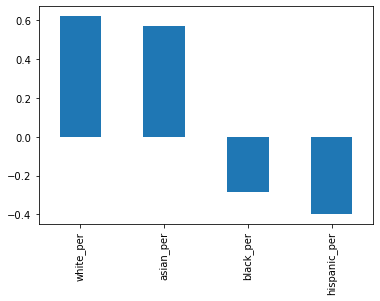

In [22]:
race = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()["sat_score"][race].plot.bar()

Terlihat bahwa sekolah dengan persentase ras kulit hitam dan hispanic yang tinggi mengakibatkan skor SAT yang rendah dan sebaliknya sekolah dengan persentase ras kulit putih dan asian mempunyai skor SAT yang tinggi.

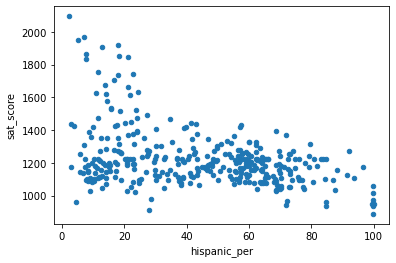

In [23]:
combined.plot.scatter("hispanic_per","sat_score")

Terlihat bahwa memang ada korelasi yang menunjukkan persentasi ras hispanic yang tinggi di sekolah mengakibatkan skor SAT yang rendah.

In [24]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Sekolah diatas memang SMA yang ditunjukkan untuk imigrant di US. Sehingga berkorelasi dengan ell_percent yang kita inspeksi diatas dimana sekolah dengan english learner yang tinggi mempunyai skor SAT yang rendah.

In [25]:
combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Sekoalh diatas merupakan sekolah yang berspesialisasi ke sains dan teknologi yang mendapatkan dana tambahan, dan hanya siswa yang lulus tes awal yang dapat masuk. Hal ini tidak menjelaskan persentasi hispanic yang kecil namun menjelaskan mengapa skor SAT yang tinggi.

# Analisa Skor SAT Terhadap Gender
Terakhir kita akan menganalisa bagaimana pengaruh gender terhadap nilai SAT. Apakah SAT condong membuat perempuan mendapat nilai lebih baik atau sebaliknya.

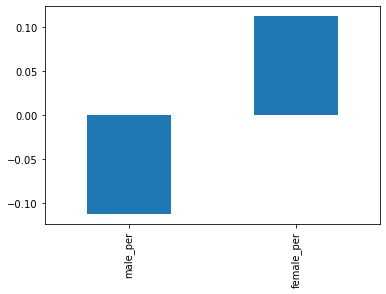

In [27]:
gender = ['male_per','female_per']
combined.corr()["sat_score"][gender].plot.bar()

Jika dilihat dari grafik diatas saja maka perempuan lebih diuntungkan terhadap SAT karena sekolah dengan persentase perempuan lebih banyak mempunyai skor SAT yang lebih tinggi.

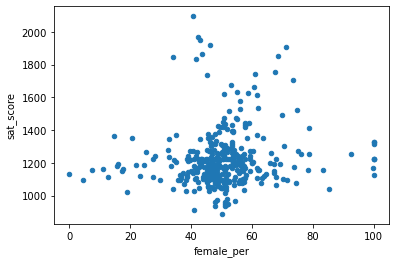

In [28]:
combined.plot.scatter("female_per","sat_score")

Namun pada scatter plot tidak terlalu terlihat korelasi antara persentase perempuan dengan skor SAT. Korelasi sebelumnya mungkin karena banyak nilai SAT yang tinggi saat persentase perempuan antara 40%-60%

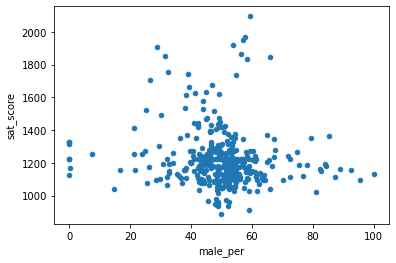

In [30]:
combined.plot.scatter("male_per","sat_score")

Sama seperti persentase perempuan nampaknya tidak ada korelasi yang kuat antara skor SAT dengan jumlah laki-laki di SMA

# Analisa Pengambil AP Test
Sebagai analisa terakhir kita akan melihat bagaimana skor SAT siswa/i yang mengambil test AP. Kita akan melihat persentase siswa/i yang mengambil AP tiap sekolah dengan rata-rata skor SAT. 

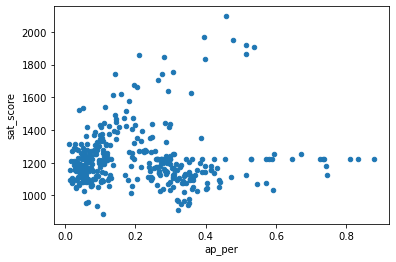

In [34]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')

Terlihat ada korelasi positif dimana siswa yang mengambil test AP cenderung mendapat skor SAT yang lebih baik. Hal ini dapat dikarenakan siswa yang mengambil AP pastinya lebih serius secara akademik dibanding yang tidak.